<a href="https://colab.research.google.com/github/VladislavasR/PP5/blob/main/PP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start of the PP5

In [2]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 30.3 MB/s 
     |████████████████████████████████| 1.6 MB 39.6 MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import Markdown, display

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import math
import matplotlib.animation as animation
from tensorflow import keras
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model

from sklearn.preprocessing import StandardScaler as scale # Standardization
from sklearn.ensemble import IsolationForest # Outlier Detection
from keras.models import Sequential # Sequential Neural Network
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping # Early Stopping Callback
from kerastuner.tuners import RandomSearch
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [4]:
!wget https://raw.githubusercontent.com/VladislavasR/PP4/main/electricity_prices.csv

--2022-09-07 11:46:04--  https://raw.githubusercontent.com/VladislavasR/PP4/main/electricity_prices.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4048368 (3.9M) [text/plain]
Saving to: ‘electricity_prices.csv’

electricity_prices. 100%[===================>]   3.86M  --.-KB/s    in 0.04s   

2022-09-07 11:46:04 (94.3 MB/s) - ‘electricity_prices.csv’ saved [4048368/4048368]



In [5]:
el_prices = pd.read_csv('electricity_prices.csv')
el_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                38014 non-null  object
 1   Holiday                 38014 non-null  object
 2   HolidayFlag             38014 non-null  int64 
 3   DayOfWeek               38014 non-null  int64 
 4   WeekOfYear              38014 non-null  int64 
 5   Day                     38014 non-null  int64 
 6   Month                   38014 non-null  int64 
 7   Year                    38014 non-null  int64 
 8   PeriodOfDay             38014 non-null  int64 
 9   ForecastWindProduction  38014 non-null  object
 10  SystemLoadEA            38014 non-null  object
 11  SMPEA                   38014 non-null  object
 12  ORKTemperature          38014 non-null  object
 13  ORKWindspeed            38014 non-null  object
 14  CO2Intensity            38014 non-null  object
 15  Ac

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,10,11,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
el_prices = el_prices.replace('?', np.NaN)
el_prices['DateTime']=pd.to_datetime(el_prices['DateTime'], dayfirst=True)

In [7]:
# columns_to_numeric columns changes every time colab is restarted. Need to update which columns change to numeric on every load.
columns_to_numeric = ['ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']
el_prices[columns_to_numeric] = el_prices[columns_to_numeric].apply(pd.to_numeric)

In [8]:
el_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                38014 non-null  datetime64[ns]
 1   Holiday                 38014 non-null  object        
 2   HolidayFlag             38014 non-null  int64         
 3   DayOfWeek               38014 non-null  int64         
 4   WeekOfYear              38014 non-null  int64         
 5   Day                     38014 non-null  int64         
 6   Month                   38014 non-null  int64         
 7   Year                    38014 non-null  int64         
 8   PeriodOfDay             38014 non-null  int64         
 9   ForecastWindProduction  38009 non-null  float64       
 10  SystemLoadEA            38012 non-null  float64       
 11  SMPEA                   38012 non-null  float64       
 12  ORKTemperature          37719 non-null  float6

In [9]:
el_prices = el_prices.dropna()

In [10]:
el_data = el_prices[['SystemLoadEA','SMPEA', 'SystemLoadEP2', 'SMPEP2']]
el_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37682 entries, 0 to 38013
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SystemLoadEA   37682 non-null  float64
 1   SMPEA          37682 non-null  float64
 2   SystemLoadEP2  37682 non-null  float64
 3   SMPEP2         37682 non-null  float64
dtypes: float64(4)
memory usage: 1.4 MB


In [11]:
train = el_data[:5000].copy()
test = el_data[5000:10000].copy()
y = train['SMPEA']

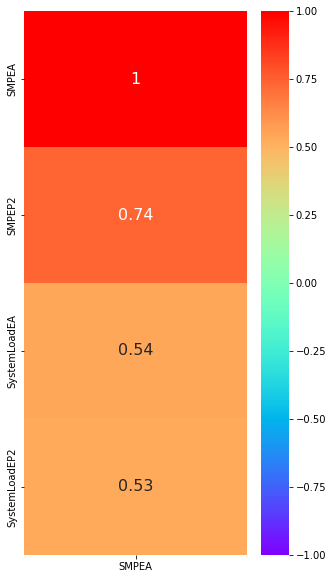

In [12]:
top_features = train.corr()[['SMPEA']].sort_values(by=['SMPEA'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

In [16]:
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(10,20,figsize=(20,10))
        sns.stripplot(x=col, y='SMPEA', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SMPEA', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

In [17]:
# takes too long with large dataset
plot_data('SMPEP2',True)

AttributeError: ignored

Error in callback <function flush_figures at 0x7fad672cff80> (for post_execute):


KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

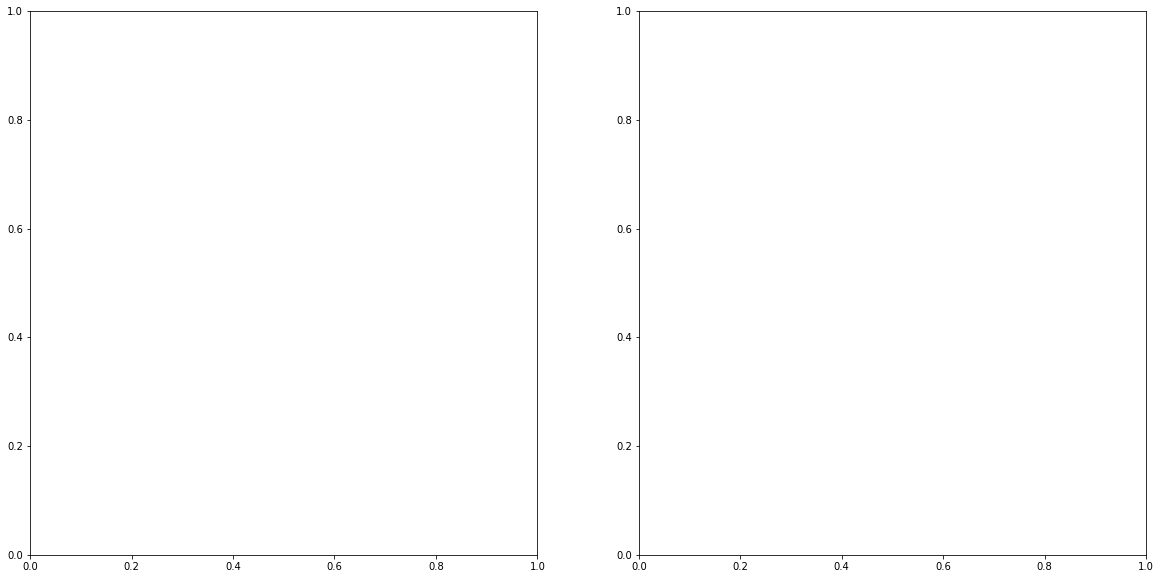

In [15]:
# takes too long with large dataset
plot_data('SystemLoadEP2',True)

In [ ]:
# takes too long with large dataset
plot_data('SystemLoadEA',True)

In [18]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 976
Number of rows without outliers: 4024


In [19]:
X = train.copy()
X.drop(['SMPEA'],axis=1,inplace=True) # Dropped the y feature
y = train['SMPEA'].values

In [20]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 4)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

In [21]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=5,
    executions_per_trial=3,
    directory='model_dir',
    project_name='Electricity_Price_Prediction')
 
tuner.search(X[800:],y[800:],batch_size=128,epochs=5,validation_data=(X[:800],y[:800]))

Trial 5 Complete [00h 00m 07s]
val_mse: 56.31608454386393

Best val_mse So Far: 51.41204579671224
Total elapsed time: 00h 00m 36s


In [22]:
model = tuner.get_best_models(1)[0]

In [23]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 320)               1280      
                                                                 
 dense_5 (Dense)             (None, 384)               123264    
                                                                 
 dense_6 (Dense)             (None, 352)               135520    
                                                                 
 dense_7 (Dense)             (None, 448)               158144    
                                                                 
 dense_8 (Dense)             (None, 160)               71840     
                                                                 
 dense_9 (Dense)             (None, 160)               25760     
                                                                 
 dense_10 (Dense)            (None, 32)               

Epoch 1/1000
29/29 [==============================] - 1s 23ms/step - loss: 527.0319 - val_loss: 204.9521
Epoch 2/1000
29/29 [==============================] - 0s 17ms/step - loss: 85.2976 - val_loss: 229.6200
Epoch 3/1000
29/29 [==============================] - 0s 16ms/step - loss: 73.4743 - val_loss: 212.8057
Epoch 4/1000
29/29 [==============================] - 0s 17ms/step - loss: 73.3817 - val_loss: 299.7985
Epoch 5/1000
29/29 [==============================] - 0s 16ms/step - loss: 77.0322 - val_loss: 262.9381
Epoch 6/1000
29/29 [==============================] - 0s 17ms/step - loss: 73.5400 - val_loss: 198.6445
Epoch 7/1000
29/29 [==============================] - 0s 16ms/step - loss: 73.2886 - val_loss: 237.6343
Epoch 8/1000
29/29 [==============================] - 0s 17ms/step - loss: 76.1046 - val_loss: 174.2868
Epoch 9/1000
29/29 [==============================] - 0s 16ms/step - loss: 74.3924 - val_loss: 164.5134
Epoch 10/1000
29/29 [==============================] - 0s 17ms/

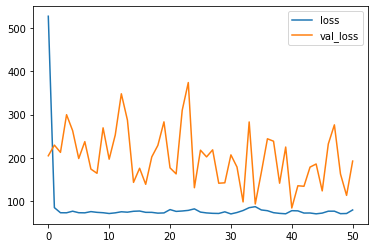

In [24]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot()

In [25]:
def create_model_sigmoid():
    # create model
    model_sigmoid = Sequential()
    model_sigmoid.add(Dense(320, input_dim=X.shape[1], activation='sigmoid'))
    model_sigmoid.add(Dense(384, activation='sigmoid'))
    model_sigmoid.add(Dense(352, activation='sigmoid'))
    model_sigmoid.add(Dense(448, activation='sigmoid'))
    model_sigmoid.add(Dense(160, activation='sigmoid'))
    model_sigmoid.add(Dense(160, activation='sigmoid'))
    model_sigmoid.add(Dense(32, activation='sigmoid'))
    model_sigmoid.add(Dense(1))
    # Compile model
    model_sigmoid.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model_sigmoid
model_sigmoid = create_model()
model_sigmoid.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 320)               1280      
                                                                 
 dense_13 (Dense)            (None, 384)               123264    
                                                                 
 dense_14 (Dense)            (None, 352)               135520    
                                                                 
 dense_15 (Dense)            (None, 448)               158144    
                                                                 
 dense_16 (Dense)            (None, 160)               71840     
                                                                 
 dense_17 (Dense)            (None, 160)               25760     
                                                                 
 dense_18 (Dense)            (None, 32)               

Epoch 1/1000
29/29 [==============================] - 1s 20ms/step - loss: 69.3783 - val_loss: 119.2270
Epoch 2/1000
29/29 [==============================] - 0s 17ms/step - loss: 70.8584 - val_loss: 237.3767
Epoch 3/1000
29/29 [==============================] - 0s 17ms/step - loss: 69.9765 - val_loss: 195.1979
Epoch 4/1000
29/29 [==============================] - 0s 16ms/step - loss: 68.3919 - val_loss: 210.4962
Epoch 5/1000
29/29 [==============================] - 0s 17ms/step - loss: 69.9890 - val_loss: 222.3556
Epoch 6/1000
29/29 [==============================] - 1s 27ms/step - loss: 70.0941 - val_loss: 246.7843
Epoch 7/1000
29/29 [==============================] - 1s 28ms/step - loss: 69.6516 - val_loss: 226.5417
Epoch 8/1000
29/29 [==============================] - 1s 25ms/step - loss: 69.1880 - val_loss: 190.0877
Epoch 9/1000
29/29 [==============================] - 0s 16ms/step - loss: 70.8210 - val_loss: 250.9051
Epoch 10/1000
29/29 [==============================] - 0s 17ms/s

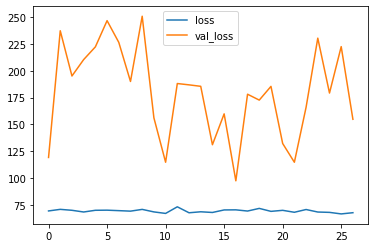

In [32]:
early_stop_sig = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model_sigmoid.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[early_stop])
losses_sig = pd.DataFrame(model_sigmoid.history.history)
losses_sig.plot()

In [36]:
def create_model_tanh():
    # create model
    model_tanh = Sequential()
    model_tanh.add(Dense(320, input_dim=X.shape[1], activation='tanh'))
    model_tanh.add(Dense(384, activation='tanh'))
    model_tanh.add(Dense(352, activation='tanh'))
    model_tanh.add(Dense(448, activation='tanh'))
    model_tanh.add(Dense(160, activation='tanh'))
    model_tanh.add(Dense(160, activation='tanh'))
    model_tanh.add(Dense(32, activation='tanh'))
    model_tanh.add(Dense(1))
    # Compile model
    model_tanh.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model_sigmoid
model_tanh = create_model()
model_tanh.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 320)               1280      
                                                                 
 dense_37 (Dense)            (None, 384)               123264    
                                                                 
 dense_38 (Dense)            (None, 352)               135520    
                                                                 
 dense_39 (Dense)            (None, 448)               158144    
                                                                 
 dense_40 (Dense)            (None, 160)               71840     
                                                                 
 dense_41 (Dense)            (None, 160)               25760     
                                                                 
 dense_42 (Dense)            (None, 32)               

Epoch 1/1000
29/29 [==============================] - 1s 25ms/step - loss: 915.2902 - val_loss: 187.6016
Epoch 2/1000
29/29 [==============================] - 0s 16ms/step - loss: 76.7821 - val_loss: 238.2694
Epoch 3/1000
29/29 [==============================] - 0s 17ms/step - loss: 72.8892 - val_loss: 284.8474
Epoch 4/1000
29/29 [==============================] - 0s 17ms/step - loss: 73.0012 - val_loss: 209.9832
Epoch 5/1000
29/29 [==============================] - 1s 18ms/step - loss: 73.3870 - val_loss: 187.9521
Epoch 6/1000
29/29 [==============================] - 1s 19ms/step - loss: 75.2513 - val_loss: 247.0863
Epoch 7/1000
29/29 [==============================] - 1s 19ms/step - loss: 77.7837 - val_loss: 151.6893
Epoch 8/1000
29/29 [==============================] - 0s 16ms/step - loss: 72.2480 - val_loss: 223.6023
Epoch 9/1000
29/29 [==============================] - 0s 17ms/step - loss: 73.3084 - val_loss: 197.2524
Epoch 10/1000
29/29 [==============================] - 0s 17ms/

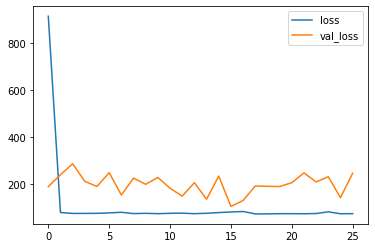

In [37]:
early_stop_tanh = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model_tanh.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[early_stop_tanh])
losses_tanh = pd.DataFrame(model_tanh.history.history)
losses_tanh.plot()

Seems like choosing the right activation curve have the beuggest impact on hitting early stop. Based on visual appereance tanh model is most fitting for this data.

Epoch 1/3
32/32 [==============================] - 1s 18ms/step - loss: 3716.6570
Epoch 2/3
32/32 [==============================] - 1s 16ms/step - loss: 88.4214
Epoch 3/3
32/32 [==============================] - 0s 15ms/step - loss: 83.2079


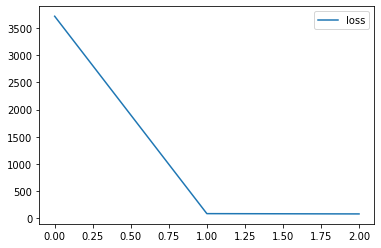

In [40]:
model_tanh = create_model() # Resetting the model.
history = model_tanh.fit(x=X,y=y,
          batch_size=128,epochs=3)
model_tanh = pd.DataFrame(model_tanh.history.history)
model_tanh.plot()

In [90]:
model_data = el_prices[['SystemLoadEA', 'SystemLoadEP2', 'SMPEP2']]
test_result = el_prices[['SMPEA']]
result = model.predict(model_data)
result = pd.DataFrame(result,columns=['SMPEA'])
result = result[['SMPEA']]
test_result = test_result.astype('float32')
compare = result.reset_index(drop=True) / test_result.reset_index(drop=True)

print(compare[4000:].mean()) # sometimes I get inf mean value.

SMPEA    0.775604
dtype: float32


I guess I'm doing something wrong but kinda expected to get better results with the same dataset that was used in ML. Maybe it's due to model not fitting for this data. Compared to ML part DL is way more sensitive to data and much more time is needed to prepare it correctly.




Fast.ai

In [93]:
import fastai
from fastai.tabular.all import *
import torch.nn as nn
fastai.__version__

'2.7.9'

In [95]:
splits = RandomSplitter(valid_pct=0.2)(range_of(el_prices[['SystemLoadEA', 'SystemLoadEP2', 'SMPEP2']]))
to = TabularPandas(el_prices, procs=[FillMissing, Normalize],
                   cont_names = ['SystemLoadEA', 'SystemLoadEP2', 'SMPEP2'],
                   y_names='SMPEA',
                   splits=splits)

In [97]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,SystemLoadEA,SystemLoadEP2,SMPEP2,SMPEA
0,3636.320068,3626.010010,56.209999,45.730000
1,4350.399902,4134.709961,50.869999,50.840000
2,4842.020020,4767.759766,78.339996,72.809998
3,4476.189941,4537.629883,58.930000,54.270000
4,4465.020020,4078.790039,105.430008,76.500000
5,3260.870117,2981.360107,42.959999,43.730000
6,3598.600098,3326.989990,46.980000,42.060001
7,3090.560059,3104.820068,57.930000,43.910000
8,4506.310059,3989.219971,51.509998,55.430000
9,3652.090088,3315.020020,38.239998,40.680000


In [103]:
learn = tabular_learner(dls, metrics=[mse])

In [105]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,mse,time
0,553.443237,475.801025,475.801025,00:05
1,607.801514,478.689514,478.689514,00:04
2,470.638794,471.017761,471.017761,00:04
3,499.093964,474.190857,474.190857,00:04
4,539.542175,477.419342,477.419342,00:04
5,503.153503,474.967499,474.967499,00:06
6,571.198975,491.877808,491.877808,00:05
7,543.133545,480.323395,480.323395,00:09
8,610.619934,478.911713,478.911713,00:04
9,580.700378,469.329895,469.329895,00:04


In [106]:
learn.show_results(max_n=20)

,SystemLoadEA,SystemLoadEP2,SMPEP2,SMPEA,SMPEA_pred
0,-0.257818,-0.352585,-0.130535,47.730000,61.745964
1,-0.256052,-0.218806,-0.056690,48.490002,63.566822
2,2.037609,2.018837,1.026078,90.330002,118.343353
3,-0.401099,-0.192377,-0.294253,53.110001,53.523422
4,-0.586450,-0.594474,-0.062987,42.320000,57.313454
5,-0.972411,-0.933727,-0.853240,46.470001,40.743156
6,-0.207218,0.003974,-0.083881,48.980000,60.921070
7,-1.961352,-1.852164,-0.410744,44.700001,44.901016
8,0.466095,0.566919,-0.168889,61.709999,65.434067
9,-1.341648,-1.068206,-0.392140,45.410000,47.737469


Fast.ai for me at least is way easier to use and faster to get results. Although only for beggining. Later we can see that as per other networks the most important part of model "tuning" is correct data injection. I think that data normalization is most important part of DL tuning. Later you can choose differnt activation curves or loss parameters. But if your data is not normalized no matter what you do your results will vary greatly.
Some parts of this code was taken from the web and other from colabs provided. I just tried to adjust it to the datased from PP4 as I wanted to compare ML to DL. Maybe this dataset is not optimal to use for such models but investigating data takes a lot of time and as we can see it is most important part. Both networks privided not very accurate results but I know that I injested only small part of data from this dataset. Later I will try configure models to take more inputs from this table.